<a href="https://colab.research.google.com/github/gmlejarza/quantum_algorithms/blob/master/vqe(updated).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

** Labwork for Hamiltonian Simulation **



# VQE tutorials

When running in collab we need to install the libraries we need for the tutorial.  In the VQE tutorial, we will be installing qiskit and pyscf.  These commands generally take about 20 seconds to run.

In [1]:
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 5.0 MB/s 
     |████████████████████████████████| 18.0 MB 359 kB/s 
     |████████████████████████████████| 240 kB 52.5 MB/s 
     |████████████████████████████████| 112 kB 69.7 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 49 kB 4.2 MB/s 
     |████████████████████████████████| 49 kB 6.6 MB/s 
     |████████████████████████████████| 1.6 MB 49.5 MB/s 
     |████████████████████████████████| 37.5 MB 1.4 MB/s 
     |████████████████████████████████| 943 kB 46.9 MB/s 
     |████████████████████████████████| 4.1 MB 26.6 MB/s 
     |████████████████████████████████| 112 kB 26.4 MB/s 
  Created wheel for qiskit: filename=qiskit-0.37.0-py3-none-any.whl size=12028 sha256=63c9d4d27d743ff111ec8510a031cfa532b805bded5f9a899cdf921c6a9be506
  Stored in directory: /root/.cache/pip/wheels/ed/f9/fa/3ed81

In [2]:
!pip install pyscf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 37.5 MB 1.3 MB/s 


In [3]:
from qiskit.opflow import X, Y, Z
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import SPSA
from qiskit.providers.basicaer import StatevectorSimulatorPy
from qiskit.algorithms import VQE, NumPyMinimumEigensolver

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In this first example, we will be testing a hardware efficient ansatz for a toy hamiltonian on 3 qubits.   Below we first set a few parameters that will define our simulation, which includes the number of optimization runs and the number of qubits for our test Hamiltonian.  

We create a simple Hamiltonian $H = Z_0 Z_1 Y_2 + X_0 Y_1 Z_2$

In the following steps we will define a circuit ansatz, the Hamiltonian of interest, and an optimizer, which will all eventually be passed to the Qiskit VQE algorithm.

In [7]:
num_runs = 20
num_qubits = 3
hamiltonian = (Z ^ Z ^ Y) - (X ^ Y ^ Z)

Using qiskit routines, we can take the Hamiltonian above and calculate the lowest eigenvalue.  This is done purely in terms of matrices in these steps and is done without approximation.  The input to the following functions on requires us to pase the hamiltonian ot the numpy eigen solver. 

In [8]:
exact_solver = NumPyMinimumEigensolver()
exact_groundstate_energy = exact_solver.compute_minimum_eigenvalue(hamiltonian).eigenvalue.real
print(f'Exact groundstate eigenvalue: {exact_groundstate_energy:.4f}')

Exact groundstate eigenvalue: -1.4142


At this step we define the ansatz.  For our toy Hamiltonian we will use a hardware efficient ansatz.  With such an ansatz gates are layered with they hope that a wide range of states may be obtained.  A single layer of a variational form specifies a certain pattern of single qubit rotations and CX gates.  The depth determines how many variational parameters we will have.  The more variational parameters, the longer the circuit but also the more accuracte the circuit.  In the following fuction, EfficientSU2, we have to specify the number of qubits, the number of layers, and the geometry of the underlying qubits for determining which edges the 2 qubit gates are connected.

In [20]:
# VQE ansatz definition
ansatz = EfficientSU2(num_qubits,reps=4, entanglement='linear')#G before it was a 2

We will now define the optimizer to SPSA.   We also define random starting parameters for the circuit ansatz here.  We will be investigating different starting points for the circuit ansatz as one of the exercises.  Note that we are starting maxiter=50, which can be adjusted later to allow the optimizer to perform more optimization steps if needed.

In [37]:
optimizer = SPSA(maxiter=100)#G before it was 50
initial_point = np.random.random(ansatz.num_parameters)

Now we pass in our setup to the VQE algorithm in Qiskit.

In [38]:
vqe = VQE(ansatz=ansatz,
          optimizer=optimizer,
          initial_point=initial_point,
          # quantum_instance=QasmSimulatorPy())
          quantum_instance=StatevectorSimulatorPy())

VQE involves an optimization step, which is the next part of the tutorial.  Optimization isn't always straightforward, and even when optimizing on classical hardware without noise, local minimum are often a concern.   In the following we run our VQE optimization multiple times, and print out the result.  

In [39]:
    # Iterate VQE calculation to find a good optimized circuit
    optimal_vqe_result = vqe.compute_minimum_eigenvalue(hamiltonian)
    enevals = [optimal_vqe_result.eigenvalue.real]
    diffvals = [optimal_vqe_result.eigenvalue.real - exact_groundstate_energy]
    print('Starting VQE runs...')
    for ii in range(num_runs):

        # Generate a new initial point for the VQE
        new_initial_point = np.random.random(ansatz.num_parameters)
        vqe.initial_point = new_initial_point

        # Calculate the minimum eigenvalue
        current_vqe_result = vqe.compute_minimum_eigenvalue(hamiltonian)
             
        print(f'Finished VQE run {ii + 1}/{num_runs}.', end="\n")
  
        current_diff = np.abs(current_vqe_result.eigenvalue.real - exact_groundstate_energy)
        optimal_diff = np.abs(optimal_vqe_result.eigenvalue.real - exact_groundstate_energy)
        
        enevals.append(current_vqe_result.eigenvalue.real)
        diffvals.append(current_diff)

        print('current_ene',current_vqe_result.eigenvalue.real)
        print('current_diff',current_diff, '\n')

        if current_diff < optimal_diff:
            optimal_vqe_result = current_vqe_result


Starting VQE runs...
Finished VQE run 1/20.
current_ene -8.701462103351178
current_diff 0.15629172223191468 

Finished VQE run 2/20.
current_ene -8.853995116495247
current_diff 0.003758709087845702 

Finished VQE run 3/20.
current_ene -8.751323747754995
current_diff 0.10643007782809732 

Finished VQE run 4/20.
current_ene -8.708766127447774
current_diff 0.14898769813531842 

Finished VQE run 5/20.
current_ene -8.710472210168106
current_diff 0.14728161541498608 

Finished VQE run 6/20.
current_ene -8.853746685154956
current_diff 0.004007140428136324 

Finished VQE run 7/20.
current_ene -8.851023552597205
current_diff 0.006730272985887353 

Finished VQE run 8/20.
current_ene -8.852480448339202
current_diff 0.005273377243890209 

Finished VQE run 9/20.
current_ene -8.853281688657455
current_diff 0.00447213692563686 

Finished VQE run 10/20.
current_ene -8.709463423709051
current_diff 0.14829040187404097 

Finished VQE run 11/20.
current_ene -8.854796588610238
current_diff 0.00295723697285

Lets plot the individual optimizations and see what sort of variation we get for the energies.

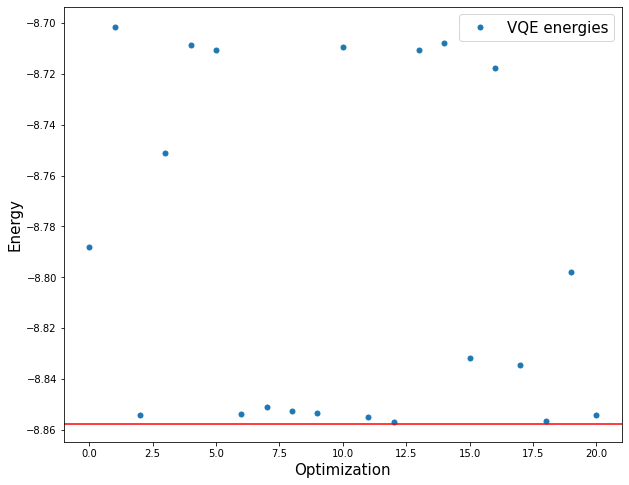

In [40]:
plt.figure(figsize=(10,8))
plt.plot(enevals, label='VQE energies',marker='.',linestyle='None',markersize=10.0)
plt.axhline(exact_groundstate_energy,color='r')
plt.xlabel('Optimization', fontsize=15)
plt.ylabel('Energy', fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.show()

You are likely to see a descent amount of scatter in the data. But hopefully you also see a lot of optimizations near the ground state energy.  Lets sort our data and replot.

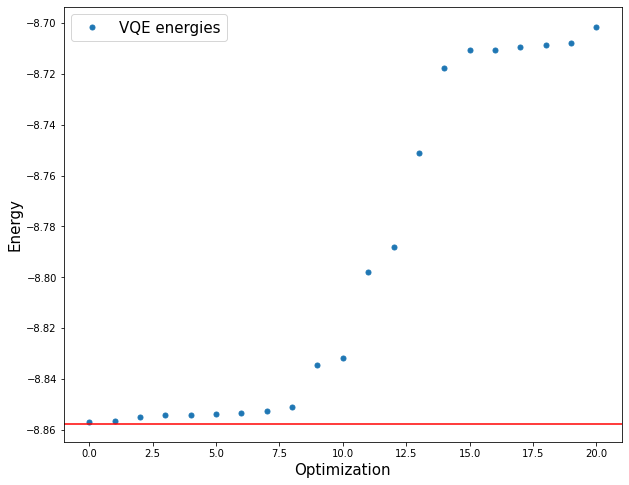

In [41]:
enevals.sort()
plt.figure(figsize=(10,8))
plt.plot(enevals, label='VQE energies',marker='.',linestyle='None',markersize=10.0)
plt.axhline(exact_groundstate_energy,color='r')
plt.xlabel('Optimization', fontsize=15)
plt.ylabel('Energy', fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.show()

For a typical run, you are likely to see a lot of data close to the exact answer, but  also some amount of values that are less converged. 

It is important to consider why this is happening.  We have already mentioned there might be local minima, but for this simple example, that is less likely to be the issue.  More likley we are stopping the optimization before it finishes (with the maxiter variable set to 50).   As an exercise one may consider increasing this value and reploting the distribution of energies.  Do all the values converge to near the optimal energy with increasing maxiter?   

We note here that it is important to make sure an optimization has converged before stopping a run. There are lots of techniques described in the literature that describe this further.  However, for more complicated examples there is no guarantee that one will find the global minimia.

Exercise:   Rerun the previous examples with varying number of layers in the hardware efficient ansatz.   For example, try with 4 layers with 20 optimization runs.   Plot the average and best results as a function of layers.  Do you get better results with increased number of layers?   In general we expect that more complex circuits will lead to better results, but there is always the possibility we will need to more resources to optimize such an ansatz.  The situation is even more difficult when one includes noise into the optmization.

### VQE Molecular Example

When running VQE for molecular systems, we need to install the qiskit nature library. This should take under 10 seconds to run.

In [5]:
!pip install qiskit_nature

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.9 MB/s 


There are a lot of different utilities in Qiskit nature we will use.  We describe many of them as we go through the tutorial. 

In [6]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper
from qiskit_nature.properties.second_quantization.electronic import ParticleNumber
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer

from qiskit_nature.algorithms import VQEUCCFactory
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.circuit.library import EfficientSU2, ExcitationPreserving


from qiskit.providers.basicaer import StatevectorSimulatorPy  # local simulator
from qiskit.providers.aer import StatevectorSimulator

When running a molecular system, in general one starts off with the geometry, charge, and spin of the molecular system of interest.   We are going to start by looking at Lithum Hydride, near equilibrium, neutral charge,  in a spin singlet configuration.    The following two lines are used to specify this.  Note that the center of origin for the geomtry of the molecule is arbitrary, and in this case we set the Li atom at the origin, and displace the Hydrogen atom along the z-axis.

In [26]:
bond_distance = 1.5949  # in Angstrom

In [28]:
molecule = Molecule(
    geometry=[["Li", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, bond_distance]]], charge=0, multiplicity=1
)


We are now prepared to call Pyscf.  Pyscf is an external electronic structure library that can be called by Qiskit.  Other libraries are also compatible with Qiskit.

To run quantum chemistry instances on quantum computers, in most cases it is necessary to run a mean field simulation to generate the second quantized operators over a set of orthonormal orbitals.   The following two lines uses a Qiskit wrapper to make this call to pyscf and import all the information necessary to create the Hamiltonian.   

Note that one of the inputs here is 'basis'.  The input used here is sto3g, which is a minimal basis that creates a toy model of the LiH molecule.  Other more realistic basis sets that one might want to study include the Dunning basis sets.  However, the sto3g basis is a 12 qubit example, and the Dunning basis sets are in general much bigger, and not suitable to run in this tutorial.

In [29]:
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.AUTO
)

In [30]:
properties = driver.run()

The following line prints out information that was returned by Pyscf.  Much of it is numerical data that can be ignored by the user.  However, there is a lot of information printed here that can be useful to better understand what is happening, and for debugging purposes when things go wrong.   Scroll through the properties  data and identify information related to the number of spin orbitals and number of particles. 

In [31]:
print(properties)

ElectronicStructureDriverResult:
	DriverMetadata:
		Program: PYSCF
		Version: 2.0.1
		Config:
			atom=Li 0.0 0.0 0.0;H 0.0 0.0 1.5949
			unit=Angstrom
			charge=0
			spin=0
			basis=sto3g
			method=rhf
			conv_tol=1e-09
			max_cycle=50
			init_guess=minao
			max_memory=4000
			
	ElectronicBasisTransform:
		Initial basis: atomic
		Final basis: molecular
		Alpha coefficients:
		[0, 0] = 0.9912453915551007
		[0, 1] = -0.16742351757847967
		[0, 2] = -0.20997751655907093
		[0, 3] = -8.545410322020262e-17
		[0, 4] = 3.320425070688112e-18
		[0, 5] = 0.09283828644434482
		[1, 0] = 0.03267810252875784
		[1, 1] = 0.4547932532194292
		[1, 2] = 0.7996171545939431
		[1, 3] = 3.548389630028498e-16
		[1, 4] = -1.3645248092246264e-17
		[1, 5] = -0.7047248588928104
		[2, 0] = 2.1677032939962187e-18
		[2, 1] = -2.8632142339546784e-16
		[2, 2] = 1.1541031939236665e-16
		[2, 3] = 0.3302776584256897
		[2, 4] = 0.9438838214234015
		[2, 5] = 1.541223571655274e-16
		[3, 0] = -1.2183440690616682e-19
		[3, 1] =

The following lines provides use a transformation driver in Qiskit to make it easier to run model problems.   In many quantum chemistry simulations, to make things more feasible to run, one often freezes electrons or define limited active orbitals of which electrons can be excited to.  The following function, ActiveSpaceTransformer, takes in the number of particles, and the number of molecular orbitals, and uses its internal routines to define an active space calculation based on the input.  While active space simulations have to be performed carefully when trying to calculate realistic data,  for testing purposes one can expect Qiskit to provide a reasonable active space and freezing of electrons.  In our case, we reduce our simulation from a 12 qubit (6 molecular oribital) simulation to a 6 qubit example.   While this reduces the overall accuracy of the simulation when compared to experiment, it does allow us to test algorithms with reduced computational cost without having to worry to much about specifying all the details.   The simplified model has an exact result, which we can calculate.  Then we can also optimize our VQE with the simplified Hamiltonian and compare the two results.

In [32]:


particle_number = properties.get_property(ParticleNumber)

# specify active space transformation
active_space_trafo = ActiveSpaceTransformer(
    num_electrons=particle_number.num_particles, num_molecular_orbitals=3
)
# define electronic structure problem
problem = ElectronicStructureProblem(driver, transformers=[active_space_trafo])

The following two lines are used to convert from the fermonic quantum chemistry Hamiltonian to a qubit operator.

In [33]:
# construct qubit converter (parity mapping + 2-qubit reduction)
qubit_converter = QubitConverter(ParityMapper(), two_qubit_reduction=True)

In [34]:
# Build the qubit Hamiltonian
hamiltonian = qubit_converter.convert(problem.second_q_ops()[0], particle_number.num_particles)

We calcuate the exact solution in the following lines as benchmark data for our VQE simulations.

In [35]:
# %% Exact Solution
print('Starting ED calculation with NumPy solver...')
exact_solver = NumPyMinimumEigensolver()
exact_groundstate_solver = GroundStateEigensolver(qubit_converter, exact_solver)

exact_result = exact_groundstate_solver.solve(problem)

nuclear_repulsion_energy = exact_result.nuclear_repulsion_energy
exact_groundstate_energy = np.real(exact_result.eigenenergies[0])

print('Done')

Starting ED calculation with NumPy solver...
Done


The following is used to define the ansatz, for which we are going to use a UCCSD ansatz.   We will use an initial state from our Hartree-Fock results to start our circuit, and we will use random paramters to setup our ansatz.

In [36]:
# Define the desired ansatz
initial_state = HartreeFock(problem.num_spin_orbitals, particle_number.num_particles, qubit_converter)

# ansatz = ExcitationPreserving(hamiltonian.num_qubits, reps=1, initial_state=initial_state)
# ansatz = EfficientSU2(reps=1, initial_state=initial_state)
ansatz = UCCSD(qubit_converter=qubit_converter, num_particles=particle_number.num_particles,
               num_spin_orbitals=problem.num_spin_orbitals, initial_state=initial_state)

initial_point = np.random.random(ansatz.num_parameters)

backend = StatevectorSimulatorPy()

solver = VQE(ansatz=ansatz, initial_point=initial_point,quantum_instance=backend)

calc = GroundStateEigensolver(qubit_converter, solver)

The following lines runs a single optimization run of VQE in Qiskit

In [ ]:
print('Starting VQE Calculation...')

vqe_result = calc.solve(problem)

vqe_groundstate_energy = vqe_result.groundenergy
vqe_abs_error = np.abs(vqe_groundstate_energy - exact_groundstate_energy)
print('Done')
print(f'Exact Groundstate Eigenvalue: {exact_groundstate_energy + nuclear_repulsion_energy:>}')
print(f'VQE Absolute Error: {vqe_abs_error:.2e}')

As before, local minimum are always a problem, and we will want to run multiple times.

In [ ]:
    # Iterate VQE calculation to find a good optimized circuit
    optimal_vqe_result = solver.compute_minimum_eigenvalue(hamiltonian)
    print('Starting VQE runs...')
    ii = 0
    for ii in range(num_runs):

        # Generate a new initial point for the VQE
        new_initial_point = np.random.random(ansatz.num_parameters)
        solver.initial_point = new_initial_point

        # Calculate the minimum eigenvalue
        current_vqe_result = solver.compute_minimum_eigenvalue(hamiltonian)

        print(f'Finished VQE run {ii + 1}/{num_runs}.', end="\n")

        current_diff = np.abs(current_vqe_result.eigenvalue.real - exact_groundstate_energy)
        optimal_diff = np.abs(optimal_vqe_result.eigenvalue.real - exact_groundstate_energy)
        print('current_diff',current_diff, '\n')

        if current_diff < optimal_diff:
            optimal_vqe_result = current_vqe_result

Exercise: As with the simple Hamiltonian in the previous section, we would like to plot the energies and see the scatter in the optimization for this molecular example.  Modify the above code to make these plots.

Exercise:  In general we want to calculate the energy as a function of bonding distance between two molecules.  
Take the LiH example above, and calculate 20 distances between 0.5 and 3 angstroms, both with the exact results and the UCCSD VQE results.   Plot your results(matplotlib).

Exercise:  Stretching a bond in chemistry is much more difficult than calculating the energy at an equilbrium geometry.   We expect to see the error increase for stretched simulations than at equilibrium.   We can investigate this with the results from the previous exercise, and calculate the average error (over 20 optimizations) as a function of distance.  Plot your results(matplotlib).  Do you see a noticeable increase an error as the bond is stretched.  In this particular case you might not, as the simulation is quite small.  Finding suitably hard test cases is important when trying to benchmark an algorithm.  We currently do not have a lot of data on how well UCC will perform on a quantum computer when applied to larger problems.